# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import os
os.getcwd()

from scipy import stats

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/omitted_data/')

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out external metabolite data

In [5]:
data01 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_0.1.csv')[enzymes+fluxes+internal]
data02 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_0.2.csv')[enzymes+fluxes+internal]
data03 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_0.3.csv')[enzymes+fluxes+internal]
data04 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_0.4.csv')[enzymes+fluxes+internal]
data05 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_0.5.csv')[enzymes+fluxes+internal]
data10 = pd.read_csv('../../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_1.01.csv')[enzymes+fluxes+internal]


In [ ]:
BMCA_obj01 = BMCA.BMCA(Teusink_ant, data01)
BMCA_obj02= BMCA.BMCA(Teusink_ant, data02)
BMCA_obj03 = BMCA.BMCA(Teusink_ant, data03)
BMCA_obj04 = BMCA.BMCA(Teusink_ant, data04)
BMCA_obj05 = BMCA.BMCA(Teusink_ant, data05)
BMCA_obj10 = BMCA.BMCA(Teusink_ant, data10)


## Running ADVI

In [7]:
def run_BayesInf(BMCA_obj, n_samp=1):
    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in data10.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 35,204


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 21,737


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 16,539


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 14,728


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 14,168


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 14,509


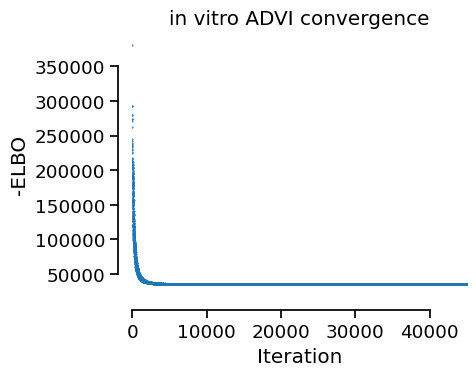

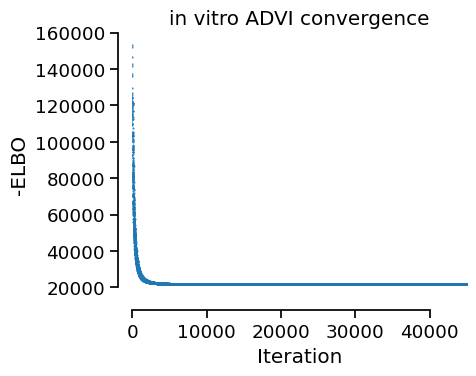

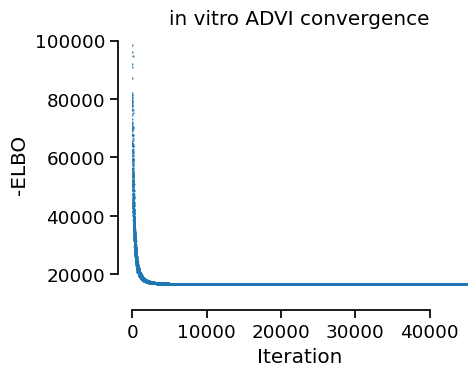

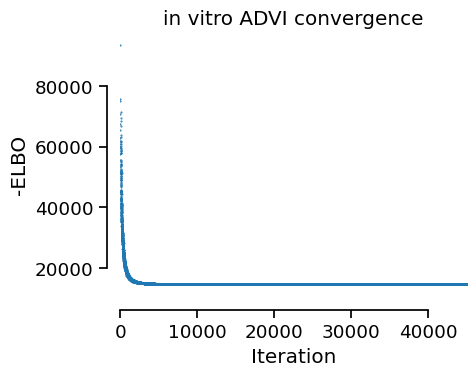

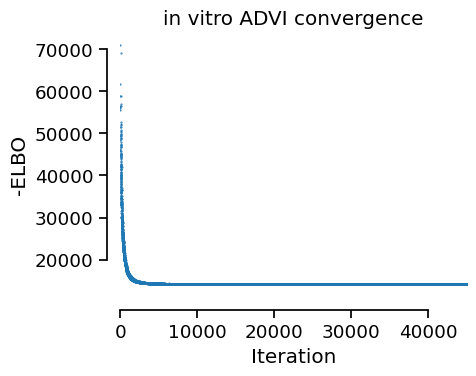

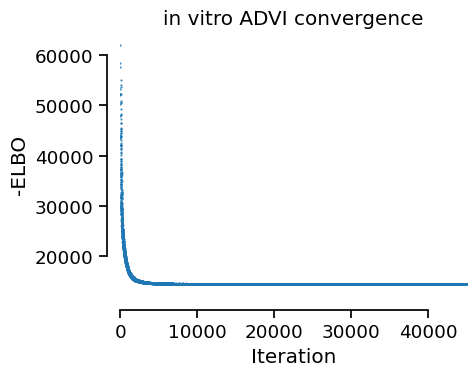

In [8]:
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)
trace10 = run_BayesInf(BMCA_obj10, n_samp=3)


## Plotting ADVI results

In [9]:
Ex01_0 = (trace01[0]['posterior']['Ex']).to_numpy().squeeze()
Ex01_1 = (trace01[1]['posterior']['Ex']).to_numpy().squeeze()
Ex01_2 = (trace01[2]['posterior']['Ex']).to_numpy().squeeze()
Ex01 = np.concatenate([Ex01_0, Ex01_1, Ex01_2])
med_Ex_advi = np.median(Ex01, axis=0)

Ex02_0 = (trace02[0]['posterior']['Ex']).to_numpy().squeeze()
Ex02_1 = (trace02[1]['posterior']['Ex']).to_numpy().squeeze()
Ex02_2 = (trace02[2]['posterior']['Ex']).to_numpy().squeeze()
Ex02 = np.concatenate([Ex02_0, Ex02_1, Ex02_2])
med_Ex_advi = np.median(Ex02, axis=0)

Ex03_0 = (trace03[0]['posterior']['Ex']).to_numpy().squeeze()
Ex03_1 = (trace03[1]['posterior']['Ex']).to_numpy().squeeze()
Ex03_2 = (trace03[2]['posterior']['Ex']).to_numpy().squeeze()
Ex03 = np.concatenate([Ex03_0, Ex03_1, Ex03_2])
med_Ex_advi = np.median(Ex03, axis=0)

Ex04_0 = (trace04[0]['posterior']['Ex']).to_numpy().squeeze()
Ex04_1 = (trace04[1]['posterior']['Ex']).to_numpy().squeeze()
Ex04_2 = (trace04[2]['posterior']['Ex']).to_numpy().squeeze()
Ex04 = np.concatenate([Ex04_0, Ex04_1, Ex04_2])
med_Ex_advi = np.median(Ex04, axis=0)

Ex05_0 = (trace05[0]['posterior']['Ex']).to_numpy().squeeze()
Ex05_1 = (trace05[1]['posterior']['Ex']).to_numpy().squeeze()
Ex05_2 = (trace05[2]['posterior']['Ex']).to_numpy().squeeze()
Ex05 = np.concatenate([Ex05_0, Ex05_1, Ex05_2])
med_Ex_advi = np.median(Ex05, axis=0)

Ex10_0 = (trace10[0]['posterior']['Ex']).to_numpy().squeeze()
Ex10_1 = (trace10[1]['posterior']['Ex']).to_numpy().squeeze()
Ex10_2 = (trace10[2]['posterior']['Ex']).to_numpy().squeeze()
Ex10 = np.concatenate([Ex10_0, Ex10_1, Ex10_2])
med_Ex_advi = np.median(Ex10, axis=0)



## Calculating FCCs

In [10]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [11]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


### Negative predictions

In [12]:
postFCC01 = estimate_CCs(BMCA_obj01, Ex01)
postFCC02 = estimate_CCs(BMCA_obj02, Ex02)
postFCC03 = estimate_CCs(BMCA_obj03, Ex03)
postFCC04 = estimate_CCs(BMCA_obj04, Ex04)
postFCC05 = estimate_CCs(BMCA_obj05, Ex05)
postFCC10 = estimate_CCs(BMCA_obj10, Ex10)


In [13]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.01x']

In [14]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [15]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.1x,-1.946105,0.009072,-0.025149,-0.257081,-0.016661,-0.020745,-0.018752,-0.014015,-0.016801,-0.020240,-0.034569,-0.040649,-0.008918,1.468751,-0.021496,-0.040066
vPGI,0.1x,0.072855,-1.917751,-0.087399,-0.893417,0.149789,0.025816,0.011262,-0.000696,-0.005862,-0.010790,-0.019863,-0.023019,-0.010007,1.748244,-0.024122,-0.018643
vGLYCO,0.1x,0.021801,-0.052982,-1.038098,-0.389449,-0.138841,-0.048443,-0.034785,-0.015167,-0.012659,-0.010251,-0.013706,-0.008626,-0.002269,0.771389,-0.005470,-0.023533
vTreha,0.1x,0.040188,-0.054332,-0.063363,-1.647714,-0.161520,-0.062219,-0.045470,-0.026372,-0.027452,-0.030255,-0.050726,-0.061176,-0.008690,1.281804,-0.020946,-0.062124
vPFK,0.1x,0.072855,0.082249,-0.087399,-0.893417,-1.850211,0.025816,0.011262,-0.000696,-0.005862,-0.010790,-0.019863,-0.023019,-0.010007,1.748244,-0.024122,-0.018643


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_25024\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

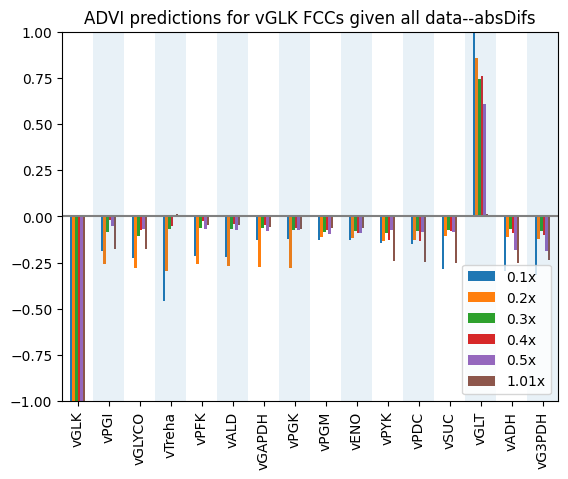

<Figure size 1600x1000 with 0 Axes>

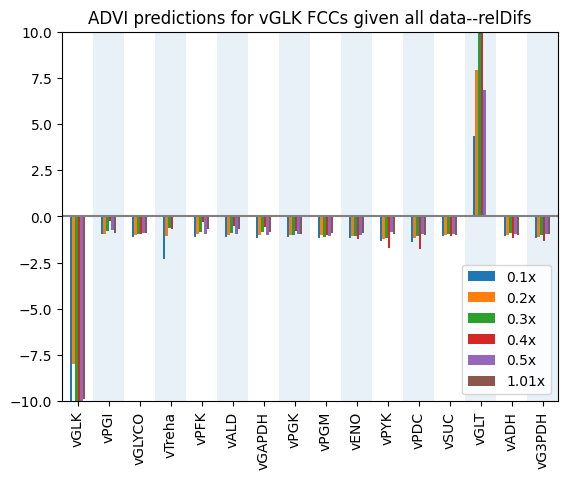

<Figure size 1600x1000 with 0 Axes>

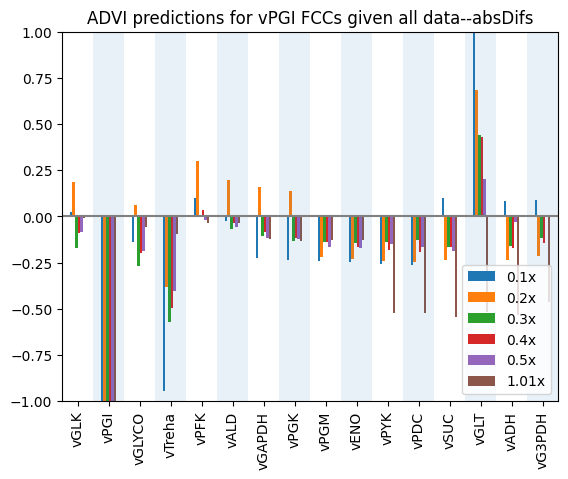

<Figure size 1600x1000 with 0 Axes>

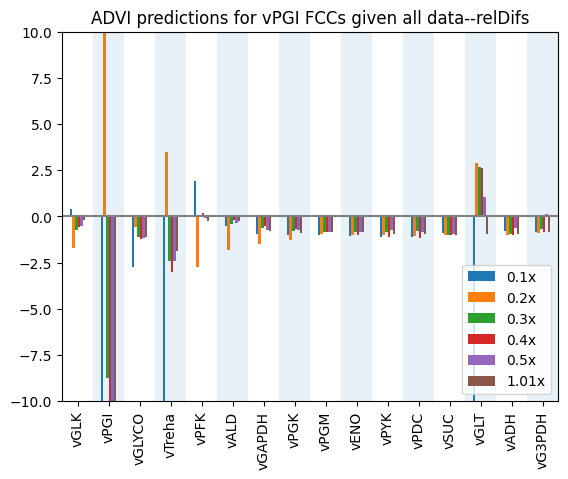

<Figure size 1600x1000 with 0 Axes>

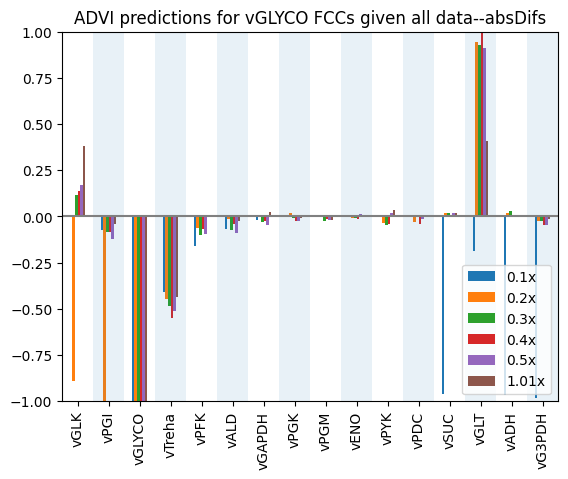

<Figure size 1600x1000 with 0 Axes>

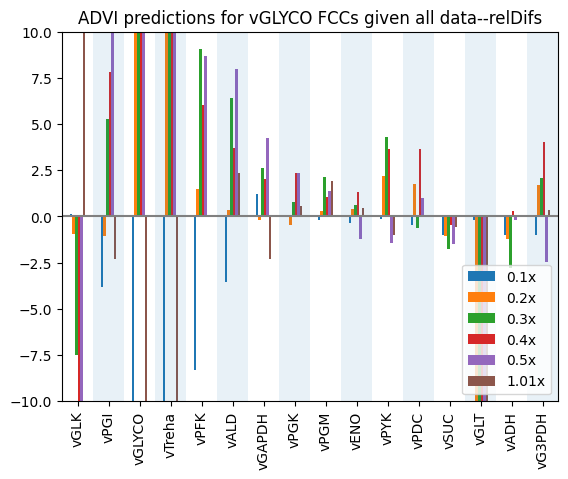

<Figure size 1600x1000 with 0 Axes>

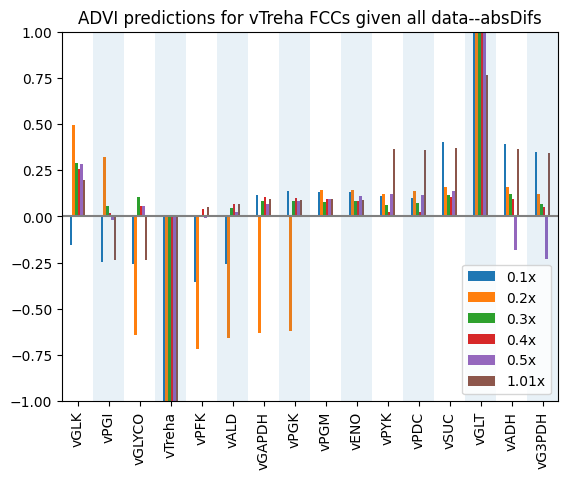

<Figure size 1600x1000 with 0 Axes>

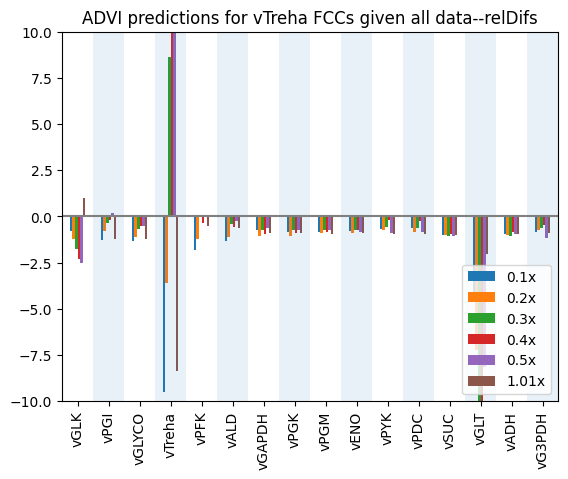

<Figure size 1600x1000 with 0 Axes>

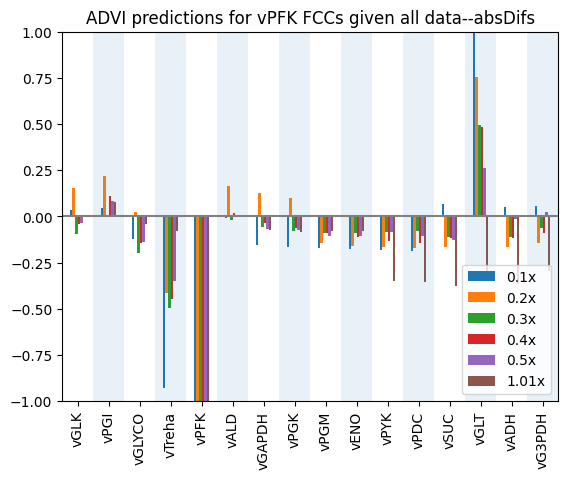

<Figure size 1600x1000 with 0 Axes>

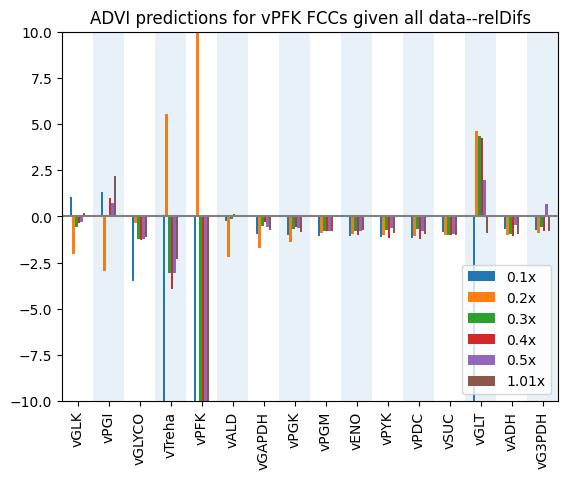

<Figure size 1600x1000 with 0 Axes>

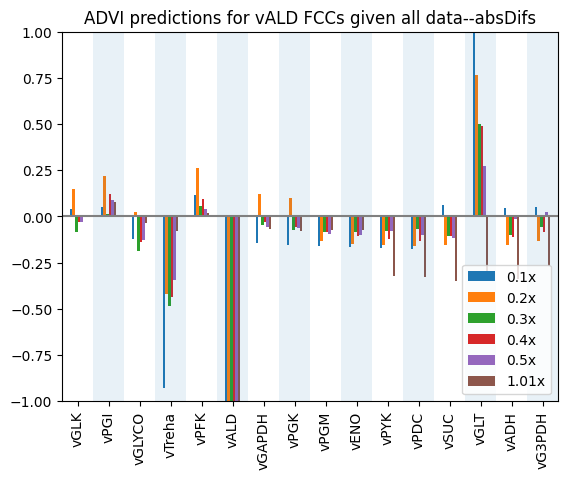

<Figure size 1600x1000 with 0 Axes>

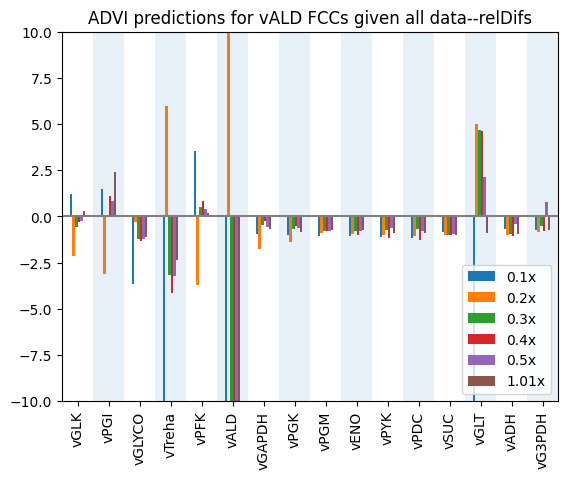

<Figure size 1600x1000 with 0 Axes>

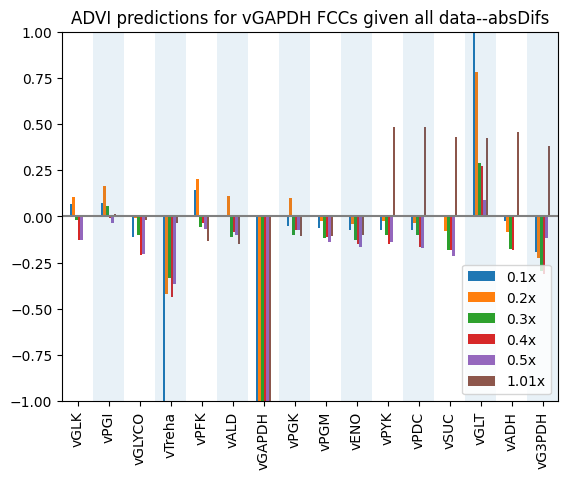

<Figure size 1600x1000 with 0 Axes>

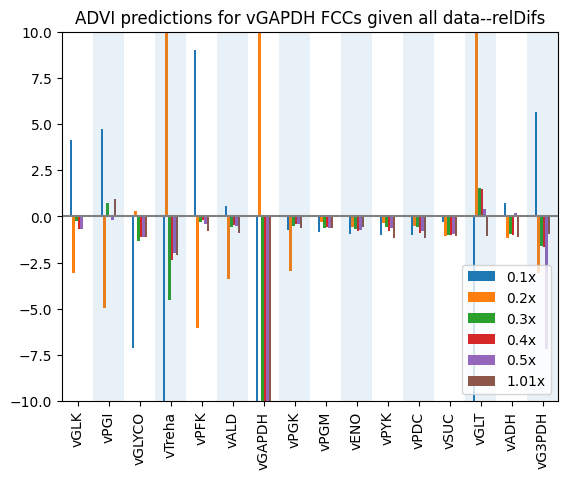

<Figure size 1600x1000 with 0 Axes>

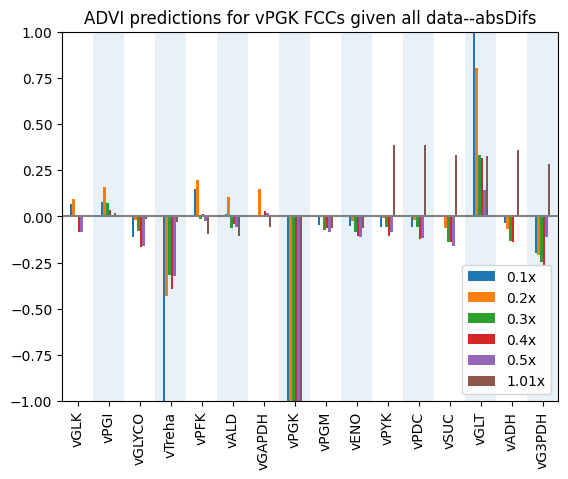

<Figure size 1600x1000 with 0 Axes>

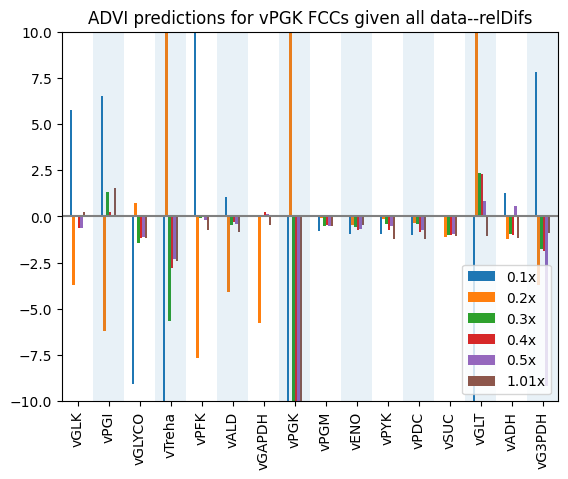

<Figure size 1600x1000 with 0 Axes>

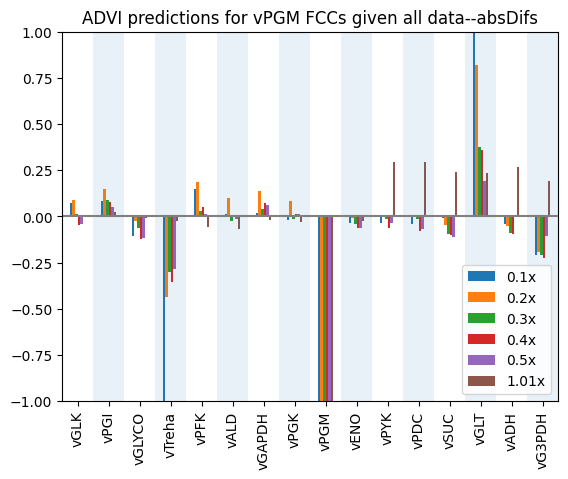

<Figure size 1600x1000 with 0 Axes>

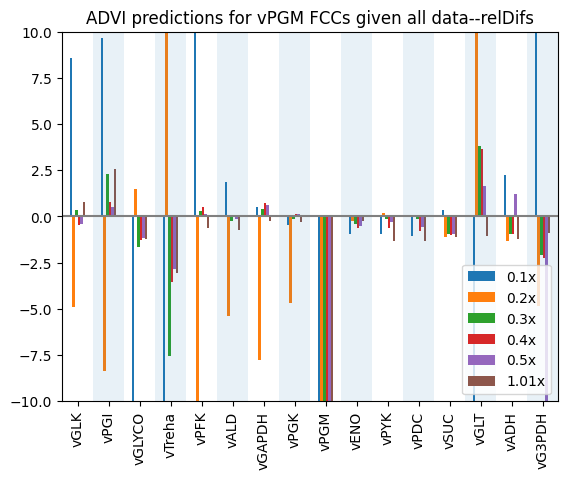

<Figure size 1600x1000 with 0 Axes>

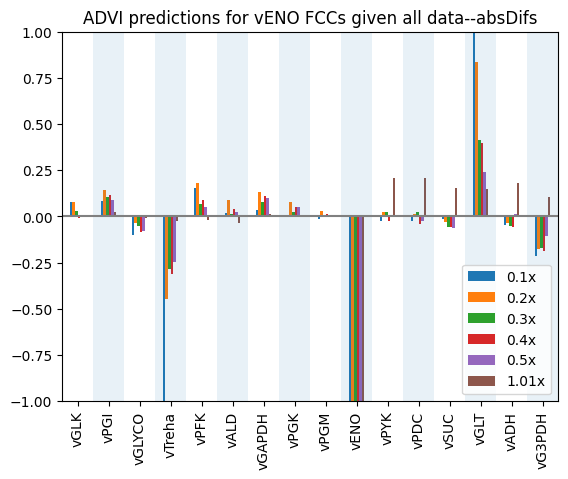

<Figure size 1600x1000 with 0 Axes>

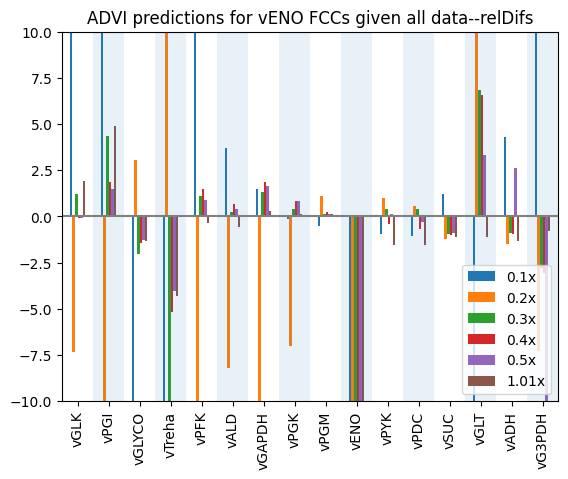

<Figure size 1600x1000 with 0 Axes>

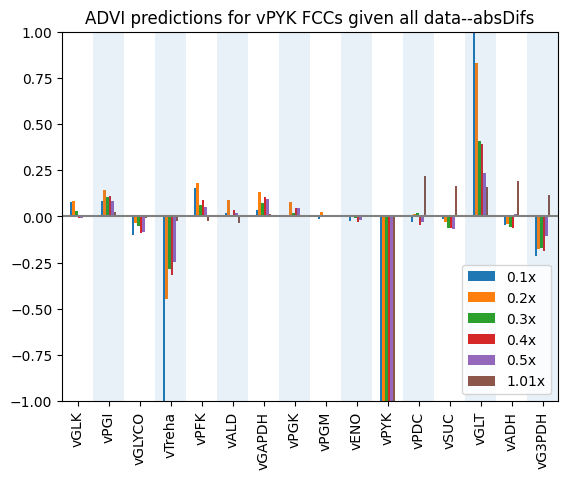

<Figure size 1600x1000 with 0 Axes>

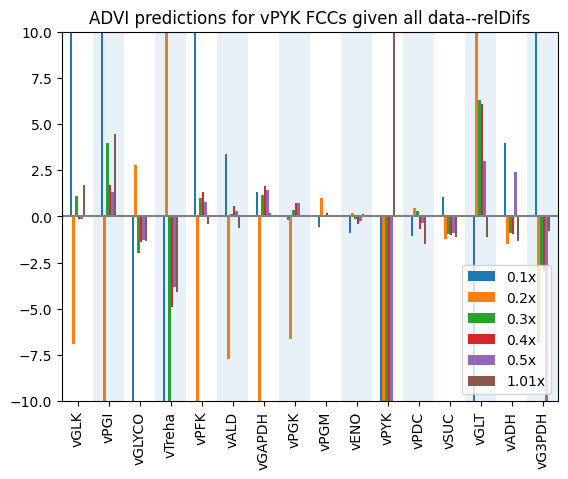

<Figure size 1600x1000 with 0 Axes>

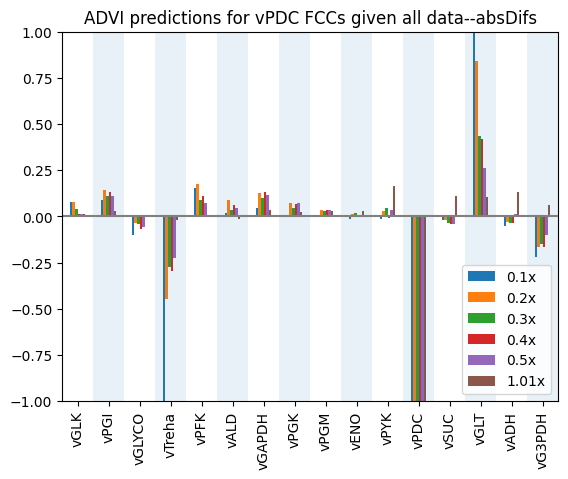

<Figure size 1600x1000 with 0 Axes>

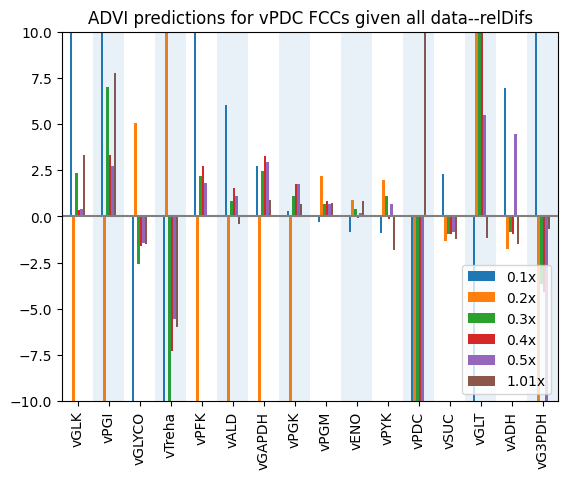

<Figure size 1600x1000 with 0 Axes>

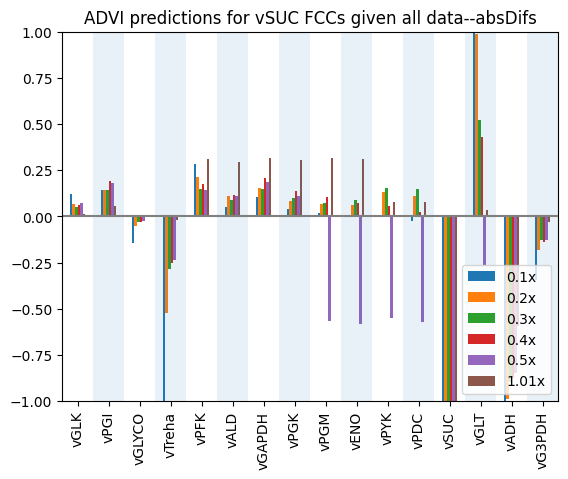

<Figure size 1600x1000 with 0 Axes>

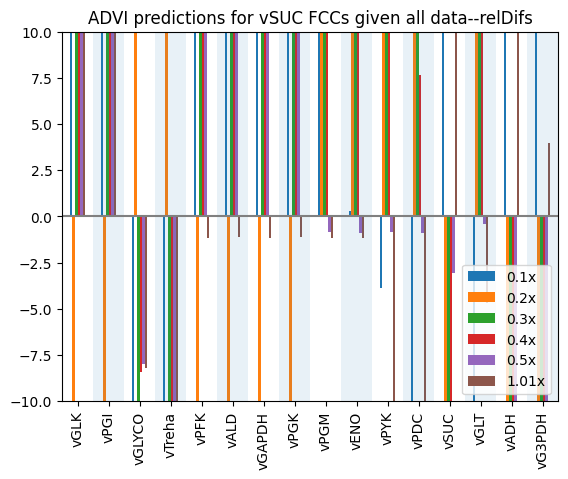

<Figure size 1600x1000 with 0 Axes>

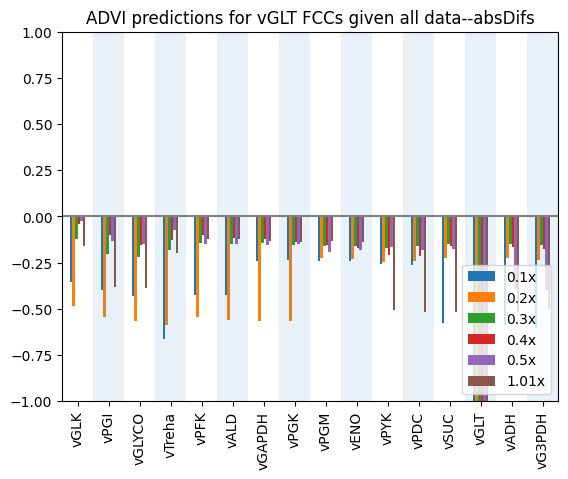

<Figure size 1600x1000 with 0 Axes>

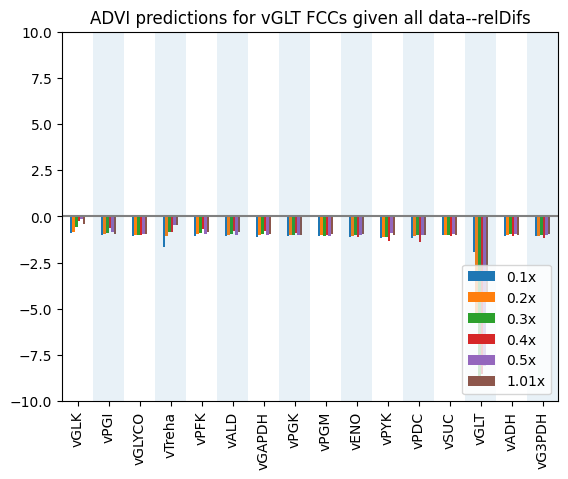

<Figure size 1600x1000 with 0 Axes>

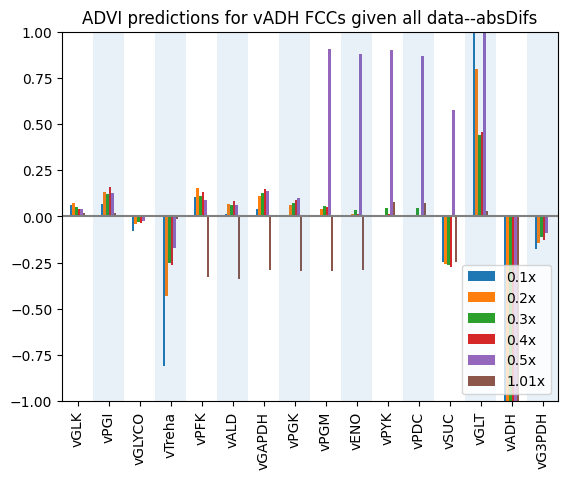

<Figure size 1600x1000 with 0 Axes>

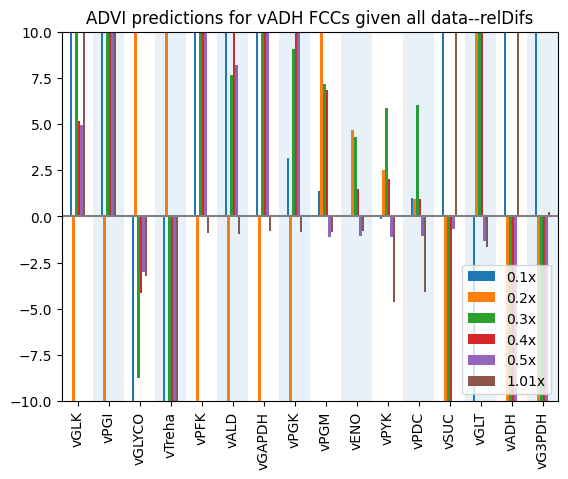

<Figure size 1600x1000 with 0 Axes>

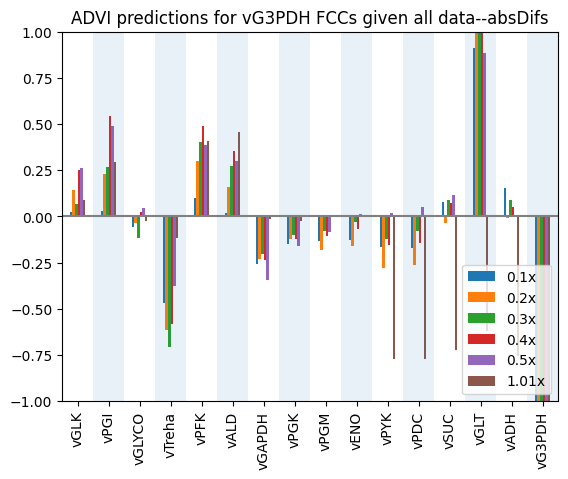

<Figure size 1600x1000 with 0 Axes>

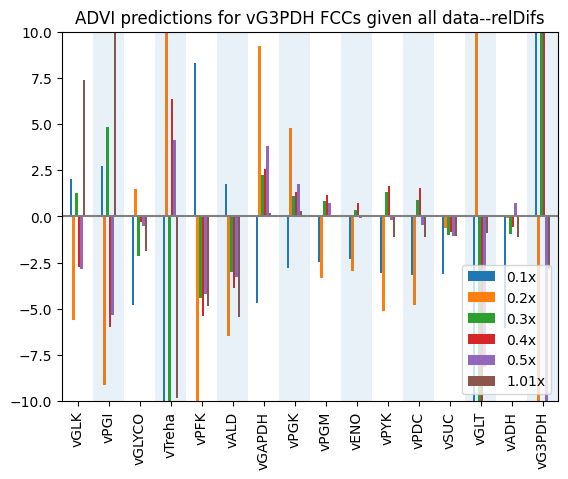

In [16]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [17]:
plt.close("all")

## Evaluating FCC ranking

In [18]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
gtFCC_rankings

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,3.0,6.0,2.0,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPGI,5.0,NaN,13.0,3.0,2.0,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,1.0,14.0,8.0
vGLYCO,3.0,4.0,NaN,2.0,5.0,6.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vTreha,2.0,3.0,6.0,NaN,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPFK,5.0,1.0,13.0,3.0,NaN,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vALD,5.0,1.0,13.0,4.0,3.0,NaN,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vGAPDH,9.0,1.0,13.0,5.0,4.0,6.0,NaN,3.0,7.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vPGK,9.0,2.0,13.0,5.0,4.0,6.0,1.0,NaN,7.0,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vPGM,9.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,NaN,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vENO,10.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,8.0,NaN,11.0,12.0,15.0,3.0,14.0,9.0


In [19]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [20]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [21]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')


,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
vGLK,1,2,2,2,2,3
vPGI,2,3,2,3,2,1
vGLYCO,1,2,1,3,2,3
vTreha,0,2,1,3,2,2
vPFK,2,3,2,3,2,1
vALD,1,2,1,2,1,2
vGAPDH,1,0,2,1,2,0
vPGK,1,1,1,2,1,1
vPGM,1,1,1,2,1,1
vENO,1,1,1,2,1,1


In [22]:
topThreeCheckdf.sum(axis=0)

0.1x     15
0.2x     24
0.3x     21
0.4x     32
0.5x     23
1.01x    23
dtype: int64